<a href="https://colab.research.google.com/github/rafael2ll/heart_disease_regression/blob/master/heart_disease_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow import keras
from sklearn import preprocessing
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
file_list = drive.ListFile({'q': "title='heart.csv'"}).GetList()
files = []
for file1 in file_list:
  files.append([file1['title'], file1['id']])

files

[['heart.csv', '11D-75Sxc-ZHlG61_buFi88YU_2v1KpW_']]

In [0]:
frame_dataset = []
for file in files:
  downloaded = drive.CreateFile({'id': file[1]})
  downloaded.GetContentFile(file[0])
  frame_dataset.append(pd.read_csv('heart.csv'))

dataset = pd.concat(frame_dataset)

### Data Set Information:


Only 14 attributes used: 1. #3 (age) 2. #4 (sex) 3. #9 (cp) 4. #10 (trestbps) 5. #12 (chol) 6. #16 (fbs) 7. #19 (restecg) 8. #32 (thalach) 9. #38 (exang) 10. #40 (oldpeak) 11. #41 (slope) 12. #44 (ca) 13. #51 (thal) 14. #58 (num) (the predicted attribute)

Complete attribute documentation: 
- age in years
- sex(1 = male; 0 = female)
- cpchest pain type:  -- 1: typical angina --  2: atypical angina --  3: non-anginal pain 
- trestbpsresting blood pressure (in mm Hg on admission to the hospital)
- cholserum cholestoral in mg/dl
- fbs(fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restecgresting electrocardiographic results
- thalachmaximum heart rate achieved
- exangexercise induced angina (1 = yes; 0 = no)
- oldpeakST depression induced by exercise relative to rest
- slopethe slope of the peak exercise ST segment
- canumber of major vessels (0-3) colored by flourosopy
- thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
- target: 1 or 0

In [0]:
dataset.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [0]:
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


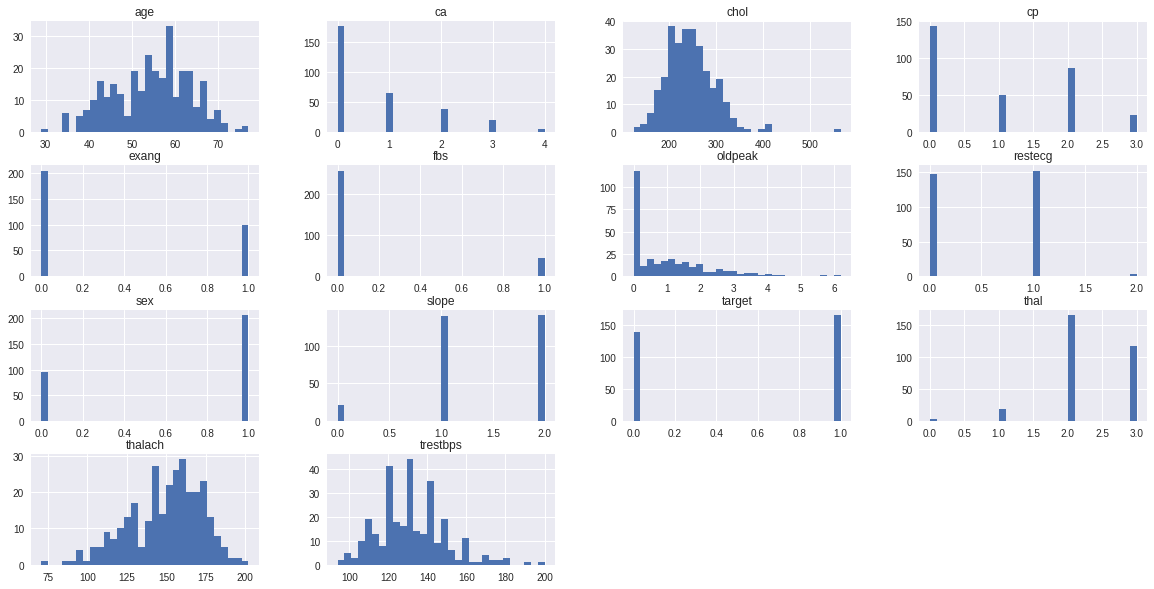

In [0]:
dataset.hist(bins=30, figsize=(20,10))
plt.show()

In [0]:
dataset.corr()['target'].T

age        -0.225439
sex        -0.280937
cp          0.433798
trestbps   -0.144931
chol       -0.085239
fbs        -0.028046
restecg     0.137230
thalach     0.421741
exang      -0.436757
oldpeak    -0.430696
slope       0.345877
ca         -0.391724
thal       -0.344029
target      1.000000
Name: target, dtype: float64

In [0]:
dataset_sex =  np.array([[int(x == 0), int(x== 1)] for x in dataset['sex']])
dataset_slope=  np.array([[int(x == 1), int(x== 2), int(x==3)] for x in dataset['slope']])
dataset.drop(['sex', 'slope'], axis = 1, inplace=True)
dataset['man'] = dataset_sex[:,0]
dataset['woman'] = dataset_sex[:,1]
dataset['up_sloping'] = dataset_slope[:,0]
dataset['flat_sloping'] = dataset_slope[:, 1]
dataset['down_sloping'] = dataset_slope[:, 2:]
dataset.head()

,age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,thal,target,man,woman,up_sloping,flat_sloping,down_sloping
0,63,3,145,233,1,0,150,0,2.3,0,1,1,0,1,0,0,0
1,37,2,130,250,0,1,187,0,3.5,0,2,1,0,1,0,0,0
2,41,1,130,204,0,0,172,0,1.4,0,2,1,1,0,0,1,0
3,56,1,120,236,0,1,178,0,0.8,0,2,1,0,1,0,1,0
4,57,0,120,354,0,1,163,1,0.6,0,2,1,1,0,0,1,0


In [0]:
heart_Y = np.array([[int(x == 0), int(x== 1)] for x in dataset['target']])

heart_X = dataset.drop('target', axis = 1)

In [0]:
def build_model(input_shape, output_shape):
  model = keras.Sequential([
    keras.layers.Dense(15, activation=tf.nn.relu, input_shape=[input_shape]),
    keras.layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(output_shape, activation = tf.nn.softmax)
  ])

  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['mae', 'mse', 'acc'])
  return model

In [0]:
model = build_model(heart_X.shape[1], heart_Y.shape[1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 15)                255       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 22        
Total params: 437
Trainable params: 437
Non-trainable params: 0
_________________________________________________________________


In [0]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

history = model.fit(heart_X, heart_Y,  epochs=200,batch_size=5, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................

0.8719008

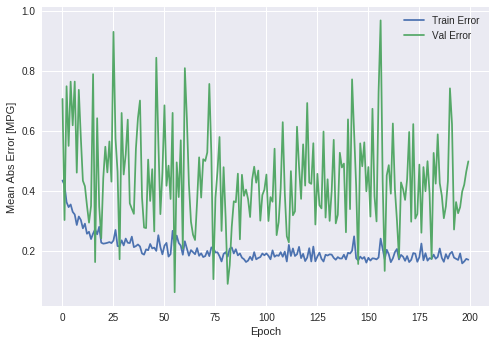

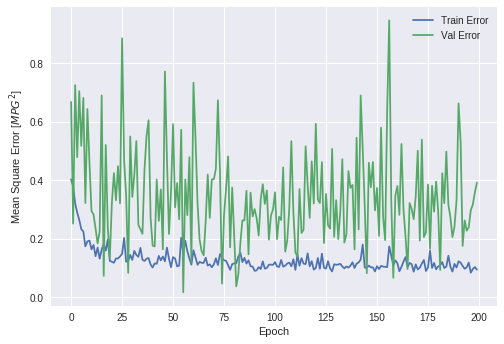

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.legend()

plot_history(history)
history.history['acc'][-1]